<a href="https://colab.research.google.com/github/YunmeiHuanghi/Mask_RCNN/blob/master/ML4T_Project_3_Access_Learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp drive/MyDrive/ML4T_data/assess_learners_2022Spr.zip .
_=!unzip assess_learners_2022Spr.zip
%cd assess_learners

/content/assess_learners


DTLearner

In [ ]:
import numpy as np  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
class DTLearner(object):  		  	   		  	  			  		 			     			  	 
    """  		  	   		  	  			  		 			     			  	 
    This is a Linear Regression Learner. It is implemented correctly.  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    :param verbose: If “verbose” is True, your code can print out information for debugging.  		  	   		  	  			  		 			     			  	 
        If verbose = False your code should not generate ANY output. When we test your code, verbose will be False.  		  	   		  	  			  		 			     			  	 
    :type verbose: bool  		  	   		  	  			  		 			     			  	 
    """  		  	   		  	  			  		 			     			  	 
    def __init__(self, leaf_size = 1,verbose=False):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        Constructor method  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        self.leaf_size = leaf_size
        self.verbose = verbose 		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    def author(self):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        :return: The GT username of the student  		  	   		  	  			  		 			     			  	 
        :rtype: str  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        return "shou42"  # replace tb34 with your Georgia Tech username


    def col_min_sum_sq_res(self, X_col, y):
        arg_sort_ids = np.argsort(X_col)
        X_sorted = X_col[arg_sort_ids]
        y_sorted = y[arg_sort_ids]

        all_res_list = []
        # go through all values
        for x_id in range(len(X_sorted)-1):
            # x_id split the X_sorted into two groups
            # which are [:x_id+1] and [x_id+1:]
            # X_sorted_left, X_sorted_right = X_sorted[:x_id+1], X_sorted[x_id+1:]
            y_sorted_left, y_sorted_right = y_sorted[:x_id+1], y_sorted[x_id+1:]
            # print(y_sorted_left)
            y_mean_left, y_mean_right = y_sorted_left.mean(), y_sorted_right.mean()
            y_res_left, y_res_right = np.sum((y_sorted_left - y_mean_left) ** 2), np.sum((y_sorted_right - y_mean_right) ** 2)
            all_res = y_res_left + y_res_right
            all_res_list.append(all_res)

        split_point_id = np.argmin(all_res_list)
        min_res = all_res_list[split_point_id]
        y_left, y_right = y_sorted[:split_point_id+1], y_sorted[split_point_id+1:]
        X_thresh = X_sorted[split_point_id] # <= X_thresh
        return X_thresh, min_res, y_left, y_right

    def pick_best_feature_id(self, X, y):
        col_num = X.shape[1]
        min_res_of_all_features = []
        y_left_list = []
        y_right_list = []
        X_thresh_list = []
        for col_id in range(col_num):
            X_col = X[:,col_id]
            X_thresh, min_res, y_left, y_right = self.col_min_sum_sq_res(X_col, y)
            X_thresh_list.append(X_thresh)
            min_res_of_all_features.append(min_res)
            y_left_list.append(y_left)
            y_right_list.append(y_right)

        # print("min_res_of_all_features=",min_res_of_all_features)
        best_feature_id = np.argmin(min_res_of_all_features)
        y_left_best = y_left_list[best_feature_id]
        y_right_best = y_right_list[best_feature_id]
        X_thresh_best = X_thresh_list[best_feature_id]
        return best_feature_id, X_thresh_best, y_left_best, y_right_best

    def pick_best_feature_based_on_correlation(self, X, y):
        corr_list = []
        for i in range(X.shape[1]):
            corr_val = np.corrcoef(X[:,i], y)[0,1]
            corr_list.append(np.abs(corr_val))
        return np.argmax(corr_list)

    # JR Quinlan
    def build_tree_JR_Quinlan(self, X, y, verbose=False):
        # if X.shape[0] == 1:
        #     return pd.DataFrame([['leaf', 1, None, None]], columns=column_list)
        self.log(f"X.shape={X.shape}, y.shape={y.shape}")
        if y.shape[0] <= self.leaf_size:
            assert y.shape[0] > 0, "empty branch"
            pred_val = y.mean()
            return np.array([[-1, pred_val, np.nan, np.nan]])
        
        
        # determine the best feature i to split on
        # best_feature_id, _, _, _ = pick_best_feature_id(X, y)
        best_feature_id = self.pick_best_feature_based_on_correlation(X, y)
        self.log(f"best_feature_id={best_feature_id}")
        col = X[:, best_feature_id]

        # if all X are equal, just return mean y
        if np.all(col == col[0]):
            # print("all X are same")
            pred_val = y.mean()
            return np.array([[-1, pred_val, np.nan, np.nan]])

        split_val = np.median(col)
        if split_val == np.max(col):
            # print("using 2nd largest as split val")
            # to avoid infi recursion, reset split_val to second largest
            split_val = np.max(col[col < np.max(col)])

        # print(f"split_val={split_val}")
        X_left = X[col <= split_val]
        X_right = X[col > split_val]
        y_left = y[col <= split_val]
        y_right = y[col > split_val]

        left_tree, right_tree = None, None
        if y_left.shape[0] > 0:
            left_tree = self.build_tree_JR_Quinlan(X_left, y_left)
        if y_right.shape[0] > 0:
            right_tree = self.build_tree_JR_Quinlan(X_right, y_right)
        root = np.array([[best_feature_id, split_val, 1, left_tree.shape[0] + 1]])
        result = np.concatenate([s for s in [root, left_tree, right_tree] if s is not None])

        return result

    # inference
    def log(self, *content):
        if self.verbose:
            print(' '.join([str(s) for s in content]))

    def tree_predict(self, tree_array, X_col):
        current_idx = 0
        output = None
        while True:
            current_idx = int(current_idx)
            self.log('index #',current_idx)
            node = tree_array[current_idx,:]
            feature = node[0]
            if feature == -1:
                output = node[1]
                self.log('reach leaf node, output is', output)
                return output
            feature_id = int(feature)
            comp_val = node[1]
            target_feature_val = X_col[feature_id]
            if target_feature_val <= comp_val:
                jump_idx = node[2]
                current_idx += jump_idx
                self.log(f'value of feature {feature_id}: {target_feature_val} <= {comp_val}','move to index', current_idx)
                continue
            else:
                jump_idx = node[3]
                current_idx += jump_idx
                self.log(f'value of feature {feature_id}: {target_feature_val} > {comp_val}','move to index', current_idx)
                continue	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    def add_evidence(self, data_x, data_y):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        Add training data to learner  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
        :param data_x: A set of feature values used to train the learner  		  	   		  	  			  		 			     			  	 
        :type data_x: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        :param data_y: The value we are attempting to predict given the X data  		  	   		  	  			  		 			     			  	 
        :type data_y: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        """
        self.tree_array = self.build_tree_JR_Quinlan(data_x, data_y)	  	  			  		 			     			  	 
        		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    def query(self, points):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        Estimate a set of test points given the model we built.  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
        :param points: A numpy array with each row corresponding to a specific query.  		  	   		  	  			  		 			     			  	 
        :type points: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        :return: The predicted result of the input data according to the trained model  		  	   		  	  			  		 			     			  	 
        :rtype: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        """
        pred_vals = []
        num_of_rows = points.shape[0]
        for col_idx in range(num_of_rows):
            X_test_col = points[col_idx,:]

            pred_val = self.tree_predict(self.tree_array, X_test_col)
            pred_vals.append(pred_val)
        return np.array(pred_vals)
        	  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
if __name__ == "__main__":  		  	   		  	  			  		 			     			  	 
    print("the secret clue is 'zzyzx'")  		  	   		  	  			  		 			     			  	 


the secret clue is 'zzyzx'


RTLearner

In [ ]:
import numpy as np  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
class RTLearner(object):  		  	   		  	  			  		 			     			  	 
    """  		  	   		  	  			  		 			     			  	 
    This is a Linear Regression Learner. It is implemented correctly.  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    :param verbose: If “verbose” is True, your code can print out information for debugging.  		  	   		  	  			  		 			     			  	 
        If verbose = False your code should not generate ANY output. When we test your code, verbose will be False.  		  	   		  	  			  		 			     			  	 
    :type verbose: bool  		  	   		  	  			  		 			     			  	 
    """  		  	   		  	  			  		 			     			  	 
    def __init__(self, leaf_size = 1,verbose=False):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        Constructor method  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        self.leaf_size = leaf_size
        self.verbose = verbose 		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    def author(self):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        :return: The GT username of the student  		  	   		  	  			  		 			     			  	 
        :rtype: str  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        return "shou42"


    def build_tree_random(self, X, y):
        self.log(f"X.shape={X.shape}, y.shape={y.shape}")
        if y.shape[0] <= self.leaf_size:
            pred_val = y.mean()
            return np.array([[-1, pred_val, np.nan, np.nan]])
        
        # determine random feature i to split on
        best_feature_id = np.random.randint(low=0, high=X.shape[1])
        self.log(f"best_feature_id={best_feature_id}")
        col = X[:, best_feature_id]
        if np.all(col == col[0]):
            # print("all X are same")
            pred_val = y.mean()
            return np.array([[-1, pred_val, np.nan, np.nan]])

        split_id1, split_id2 = np.random.randint(low=0, high=X.shape[0], size=2)
        split_val = (col[split_id1] + col[split_id2]) / 2
        
        if split_val == np.max(col):
            # print("using 2nd largest as split val")
            # to avoid infi recursion, reset split_val to second largest
            split_val = np.max(col[col < np.max(col)])


        X_left = X[col <= split_val]
        X_right = X[col > split_val]
        y_left = y[col <= split_val]
        y_right = y[col > split_val]
        
        left_tree, right_tree = None, None
        if y_left.shape[0] > 0:
            left_tree = self.build_tree_random(X_left, y_left)
        if y_right.shape[0] > 0:
            right_tree = self.build_tree_random(X_right, y_right)
        root = np.array([[best_feature_id, split_val, 1, left_tree.shape[0] + 1]])
        result = np.concatenate([s for s in [root, left_tree, right_tree] if s is not None])
        return result

    # inference
    def log(self, *content):
        if self.verbose:
            print(' '.join([str(s) for s in content]))

    def tree_predict(self, tree_array, X_col):
        current_idx = 0
        output = None
        while True:
            current_idx = int(current_idx)
            self.log('index #',current_idx)
            node = tree_array[current_idx,:]
            feature = node[0]
            if feature == -1:
                output = node[1]
                self.log('reach leaf node, output is', output)
                return output
            feature_id = int(feature)
            comp_val = node[1]
            target_feature_val = X_col[feature_id]
            if target_feature_val <= comp_val:
                jump_idx = node[2]
                current_idx += jump_idx
                self.log(f'value of feature {feature_id}: {target_feature_val} <= {comp_val}','move to index', current_idx)
                continue
            else:
                jump_idx = node[3]
                current_idx += jump_idx
                self.log(f'value of feature {feature_id}: {target_feature_val} > {comp_val}','move to index', current_idx)
                continue	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    def add_evidence(self, data_x, data_y):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        Add training data to learner  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
        :param data_x: A set of feature values used to train the learner  		  	   		  	  			  		 			     			  	 
        :type data_x: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        :param data_y: The value we are attempting to predict given the X data  		  	   		  	  			  		 			     			  	 
        :type data_y: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        """
        self.tree_array = self.build_tree_random(data_x, data_y)	  	  			  		 			     			  	 
        		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
    def query(self, points):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        Estimate a set of test points given the model we built.  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
        :param points: A numpy array with each row corresponding to a specific query.  		  	   		  	  			  		 			     			  	 
        :type points: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        :return: The predicted result of the input data according to the trained model  		  	   		  	  			  		 			     			  	 
        :rtype: numpy.ndarray  		  	   		  	  			  		 			     			  	 
        """
        pred_vals = []
        num_of_rows = points.shape[0]
        for col_idx in range(num_of_rows):
            X_test_col = points[col_idx,:]

            pred_val = self.tree_predict(self.tree_array, X_test_col)
            pred_vals.append(pred_val)
        return np.array(pred_vals)
        	  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
  		  	   		  	  			  		 			     			  	 
if __name__ == "__main__":  		  	   		  	  			  		 			     			  	 
    print("the secret clue is 'zzyzx'")  		  	   		  	  			  		 			     			  	 


the secret clue is 'zzyzx'


In [ ]:
import math

filename = "Data/ripple.csv"
inf = open(filename)  		  	   		  	  			  		 			     			  	 
data = np.array(  		  	   		  	  			  		 			     			  	 
    [list(map(float, s.strip().split(","))) for s in inf.readlines()]  		  	   		  	  			  		 			     			  	 
)  		  	   		  	  			  		 			     			  	 
                                                    
# compute how much of the data is training and testing  		  	   		  	  			  		 			     			  	 
train_rows = int(0.6 * data.shape[0])  		  	   		  	  			  		 			     			  	 
test_rows = data.shape[0] - train_rows  		  	   		  	  			  		 			     			  	 
                                                    
# separate out training and testing data  		  	   		  	  			  		 			     			  	 
train_x = data[:train_rows, 0:-1]  		  	   		  	  			  		 			     			  	 
train_y = data[:train_rows, -1]  		  	   		  	  			  		 			     			  	 
test_x = data[train_rows:, 0:-1]  		  	   		  	  			  		 			     			  	 
test_y = data[train_rows:, -1]  		  	   		  	  			  		 			     			  	 
                                                    
print(f"{test_x.shape}")  		  	   		  	  			  		 			     			  	 
print(f"{test_y.shape}")  		  	   		  	  			  		 			     			  	 

#############################
print("RTLearner")
# create a learner and train it  		  	   		  	  			  		 			     			  	 
learner = RTLearner(leaf_size = 1, verbose=False)  # create a LinRegLearner  		  	   		  	  			  		 			     			  	 
learner.add_evidence(train_x, train_y)  # train it  		  	   		  	  			  		 			     			  	 
print(learner.author())  		  	   		  	  			  		 			     			  	 
                                                    
# evaluate in sample  		  	   		  	  			  		 			     			  	 
pred_y = learner.query(train_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((train_y - pred_y) ** 2).sum() / train_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("In sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")
print(f"pred_y.shape={pred_y.shape} and train_y.shape={train_y.shape}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=train_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  		  	   		  	  			  		 			     			  	 
                                                    
# evaluate out of sample  		  	   		  	  			  		 			     			  	 
pred_y = learner.query(test_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((test_y - pred_y) ** 2).sum() / test_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("Out of sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=test_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  	




#############################
print("Bagging")
# create a learner and train it  		  	   		  	  			  		 			     			  	 
learner2 = BagLearner(RTLearner,{"leaf_size":1}, verbose=False)  # create a LinRegLearner  		  	   		  	  			  		 			     			  	 
learner2.add_evidence(train_x, train_y)  # train it  		  	   		  	  			  		 			     			  	 
print(learner2.author())  		  	   		  	  			  		 			     			  	 
                                                    
# evaluate in sample  		  	   		  	  			  		 			     			  	 
pred_y = learner2.query(train_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((train_y - pred_y) ** 2).sum() / train_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("In sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")
print(f"pred_y.shape={pred_y.shape} and train_y.shape={train_y.shape}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=train_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  		  	   		  	  			  		 			     			  	 
                                                    
# evaluate out of sample  		  	   		  	  			  		 			     			  	 
pred_y = learner2.query(test_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((test_y - pred_y) ** 2).sum() / test_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("Out of sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=test_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  

(400, 2)
(400,)
RTLearner
shou42

In sample results
RMSE: 0.0
pred_y.shape=(600,) and train_y.shape=(600,)
corr: 1.0

Out of sample results
RMSE: 0.5959662247896191
corr: 0.6310309677482111
Bagging


NameError: ignored

In sample results
RMSE: 0.48259611567122773
pred_y.shape=(600,) and train_y.shape=(600,)
corr: 0.7368103380132509

Out of sample results
RMSE: 0.6144109736732395
corr: 0.5523185081775857

In [ ]:
data = train_x[:10]
y = train_y[:10]
data.shape, y.shape

((10, 2), (10,))

Bagging

In [ ]:
import numpy as np

learner = RTLearner
bags = 5
boost = False
verbose = False
kwargs = {"leaf_size":1}

####
class BagLearner(object):
    def __init__(self, learner, kwargs={}, bags=10, boost=False, verbose=False):
        self.learner_list = []
        self.boost = boost
        self.verbose = verbose
        for i in range(bags):
            instance = learner(**kwargs, verbose=verbose)
            self.learner_list.append(instance)
        
    def add_evidence(self, data_x, data_y):
        subsample_idx = np.random.choice(range(data_x.shape[0]), size=data_x.shape[0], replace=True)
        X_sampled = data_x[subsample_idx]
        y_sampled = data_y[subsample_idx]
        for ins in self.learner_list:
            ins.add_evidence(X_sampled, y_sampled)

    
    def author(self):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        :return: The GT username of the student  		  	   		  	  			  		 			     			  	 
        :rtype: str  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        return "shou42"

    def query(self, points):
        results = []
        if not self.boost:
            # bagging
            for ins in self.learner_list:
                results.append(ins.query(points))
            results = np.column_stack(results)
            mean_results = np.mean(results, axis=1)
            
            return mean_results
        else:
            pass


In [ ]:
import LinRegLearner as lrl

InsaneLearner

In [ ]:
class InsaneLearner(object):
    def __init__(self, verbose=False):
        self.learner = BagLearner(BagLearner, kwargs={'learner':lrl.LinRegLearner, 'bags':20}, bags=20, verbose=verbose)

    def author(self):  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        :return: The GT username of the student  		  	   		  	  			  		 			     			  	 
        :rtype: str  		  	   		  	  			  		 			     			  	 
        """  		  	   		  	  			  		 			     			  	 
        return "shou42"
    
    def add_evidence(self, data_x, data_y):
        return self.learner.add_evidence(data_x, data_y)
    
    def query(self, points):
        return self.learner.query(points)


In [ ]:
# filename = "Data/ripple.csv"
# inf = open(filename)  		  	   		  	  			  		 			     			  	 
# data = np.array(  		  	   		  	  			  		 			     			  	 
#     [list(map(float, s.strip().split(","))) for s in inf.readlines()]  		  	   		  	  			  		 			     			  	 
# )  		  	   		  	  			  		 			

filename = "Data/Istanbul.csv"
inf = open(filename)
 		  	   		  	  			  		 			     			  	 
data = np.array(  		  	   		  	  			  		 			     			  	 
    [list(map(float, s.strip().split(",")[1:])) for s in inf.readlines()[1:]]  		  	   		  	  			  		 			     			  	 
)
                                                    
# compute how much of the data is training and testing  		  	   		  	  			  		 			     			  	 
train_rows = int(0.6 * data.shape[0])  		  	   		  	  			  		 			     			  	 
test_rows = data.shape[0] - train_rows  		  	   		  	  			  		 			     			  	 
                                                    
# separate out training and testing data  		  	   		  	  			  		 			     			  	 
train_x = data[:train_rows, 0:-1]  		  	   		  	  			  		 			     			  	 
train_y = data[:train_rows, -1]  		  	   		  	  			  		 			     			  	 
test_x = data[train_rows:, 0:-1]  		  	   		  	  			  		 			     			  	 
test_y = data[train_rows:, -1]  

insane_learner = InsaneLearner()
insane_learner.add_evidence(train_x, train_y)

# evaluate in sample  		  	   		  	  			  		 			     			  	 
pred_y = insane_learner.query(train_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((train_y - pred_y) ** 2).sum() / train_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("In sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")
print(f"pred_y.shape={pred_y.shape} and train_y.shape={train_y.shape}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=train_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  		  	   		  	  			  		 			     			  	 
                                                    
# evaluate out of sample  		  	   		  	  			  		 			     			  	 
pred_y = insane_learner.query(test_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((test_y - pred_y) ** 2).sum() / test_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("Out of sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=test_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  


In sample results
RMSE: 0.005345851299620485
pred_y.shape=(321,) and train_y.shape=(321,)
corr: 0.8915824016353568

Out of sample results
RMSE: 0.004071190939227556
corr: 0.8879984226801801


In [ ]:
linear = lrl.LinRegLearner()
linear.add_evidence(train_x, train_y)

# evaluate in sample  		  	   		  	  			  		 			     			  	 
pred_y = linear.query(train_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((train_y - pred_y) ** 2).sum() / train_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("In sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")
print(f"pred_y.shape={pred_y.shape} and train_y.shape={train_y.shape}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=train_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  		  	   		  	  			  		 			     			  	 
                                                    
# evaluate out of sample  		  	   		  	  			  		 			     			  	 
pred_y = linear.query(test_x)  # get the predictions  		  	   		  	  			  		 			     			  	 
rmse = math.sqrt(((test_y - pred_y) ** 2).sum() / test_y.shape[0])  		  	   		  	  			  		 			     			  	 
print()  		  	   		  	  			  		 			     			  	 
print("Out of sample results")  		  	   		  	  			  		 			     			  	 
print(f"RMSE: {rmse}")  		  	   		  	  			  		 			     			  	 
c = np.corrcoef(pred_y, y=test_y)  		  	   		  	  			  		 			     			  	 
print(f"corr: {c[0,1]}")  


In sample results
RMSE: 0.00528577751920887
pred_y.shape=(321,) and train_y.shape=(321,)
corr: 0.8934884593618794

Out of sample results
RMSE: 0.004031405446174519
corr: 0.8894927155188487


In [ ]:
def rmse(test_y, pred_y):
    return math.sqrt(((test_y - pred_y) ** 2).sum() / test_y.shape[0])

def mae(test_y, pred_y):
    return np.mean(np.abs(test_y - pred_y))

## Experiment 1

In [ ]:
import math

filename = "Data/Istanbul.csv"
inf = open(filename)
 		  	   		  	  			  		 			     			  	 
data = np.array(  		  	   		  	  			  		 			     			  	 
    [list(map(float, s.strip().split(",")[1:])) for s in inf.readlines()[1:]]  		  	   		  	  			  		 			     			  	 
)  		  	   		  	  			  		 			     			  	 
                                                    
# compute how much of the data is training and testing  		  	   		  	  			  		 			     			  	 
train_rows = int(0.6 * data.shape[0])  		  	   		  	  			  		 			     			  	 
test_rows = data.shape[0] - train_rows  		  	   		  	  			  		 			     			  	 
                                                    
# separate out training and testing data  		  	   		  	  			  		 			     			  	 
train_x = data[:train_rows, 0:-1]  		  	   		  	  			  		 			     			  	 
train_y = data[:train_rows, -1]  		  	   		  	  			  		 			     			  	 
test_x = data[train_rows:, 0:-1]  		  	   		  	  			  		 			     			  	 
test_y = data[train_rows:, -1]  

In [ ]:
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


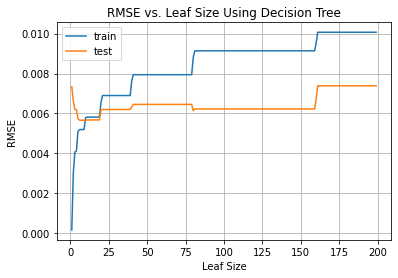

<Figure size 432x288 with 0 Axes>

In [ ]:
dt_train_errs, dt_test_errs = [], []
leaf_sizes = range(1, 200)
for i in leaf_sizes:
    dt = DTLearner(i)
    dt.add_evidence(train_x, train_y)
    pred_y = dt.query(train_x)
    train_err = rmse(train_y, pred_y)
    pred_y = dt.query(test_x)
    test_err = rmse(test_y, pred_y)
    dt_train_errs.append(train_err)
    dt_test_errs.append(test_err)


plt.plot(leaf_sizes, dt_train_errs, label='train')
plt.plot(leaf_sizes, dt_test_errs, label='test')
plt.legend()
plt.grid()
plt.xlabel("Leaf Size")
plt.ylabel("RMSE")
plt.title("RMSE vs. Leaf Size Using Decision Tree")
plt.show()
plt.savefig("rmse_vs_leaf_size_dt.pdf")

## Experiment 2

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


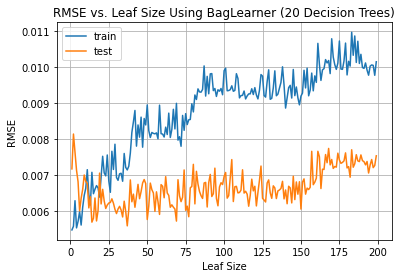

<Figure size 432x288 with 0 Axes>

In [ ]:
train_errs, test_errs = [], []
leaf_sizes = range(1, 200)
for i in leaf_sizes:
    dt = BagLearner(DTLearner, {"leaf_size":i}, 20)
    dt.add_evidence(train_x, train_y)
    pred_y = dt.query(train_x)
    train_err = rmse(train_y, pred_y)
    pred_y = dt.query(test_x)
    test_err = rmse(test_y, pred_y)
    train_errs.append(train_err)
    test_errs.append(test_err)


plt.plot(leaf_sizes, train_errs, label='train')
plt.plot(leaf_sizes, test_errs, label='test')


plt.legend()
plt.grid()
plt.xlabel("Leaf Size")
plt.ylabel("RMSE")
plt.title("RMSE vs. Leaf Size Using BagLearner (20 Decision Trees)")
plt.show()
plt.savefig("rmse_vs_leaf_size_bag.pdf")


## Experiment 3

In [ ]:
# Compare DTLearner and RTLearner
dt_train_mae, dt_test_mae = [], []
rt_train_mae, rt_test_mae = [], []

leaf_sizes = range(1, 200)

for i in leaf_sizes:
    dt = DTLearner(leaf_size=i)
    rt = RTLearner(leaf_size=i)

    dt.add_evidence(train_x, train_y)
    rt.add_evidence(train_x, train_y)

    dt_pred_y = dt.query(train_x)
    dt_train_err = mae(train_y, dt_pred_y)

    dt_pred_y = dt.query(test_x)
    dt_test_err = mae(test_y, dt_pred_y)

    rt_pred_y = rt.query(train_x)
    rt_train_err = mae(train_y, rt_pred_y)

    rt_pred_y = rt.query(test_x)
    rt_test_err = mae(test_y, rt_pred_y)

    dt_train_mae.append(dt_train_err)
    dt_test_mae.append(dt_test_err)

    rt_train_mae.append(rt_train_err)
    rt_test_mae.append(rt_test_err)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


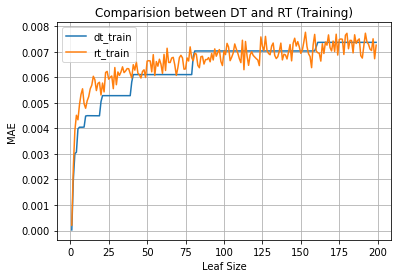

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(leaf_sizes, dt_train_mae, label='dt_train')

plt.plot(leaf_sizes, rt_train_mae, label='rt_train')

plt.legend()
plt.grid()
plt.xlabel("Leaf Size")
plt.ylabel("MAE")
plt.title("Comparision between DT and RT (Training)")
plt.show()
plt.savefig("mae_dt_and_rt_train.pdf")



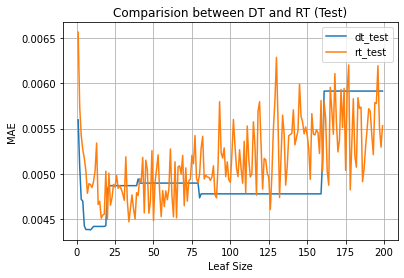

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(leaf_sizes, dt_test_mae, label='dt_test')

plt.plot(leaf_sizes, rt_test_mae, label='rt_test')

plt.legend()
plt.grid()
plt.xlabel("Leaf Size")
plt.ylabel("MAE")
plt.title("Comparision between DT and RT (Test)")
plt.show()
plt.savefig("mae_dt_and_rt_test.pdf")

In [ ]:
BagLearner()

In [ ]:
s = np.arange(10)
s

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
s1 = np.column_stack([s,s])
s1

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [ ]:
s1.mean(1)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])